# One vs All with Logistic Regression

## Necessary libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

# Load the data and define variables

In [76]:
# Taining and testing data
train = pd.read_csv('data/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test.csv')

In [77]:
# training images
X = np.array(train.drop('label', axis=1))
# training labels
y = np.array(train['label'])

# number of examples
m = len(y)

# normalize the data
# Pixel values typically range from 0 to 255.
# Dividing by 255.0 scales the data to a [0, 1] range.
# Normalization improves the performance and convergence speed of many machine learning algorithms

pixel_max_value = 255.0

X = np.array(X , dtype='float')/ pixel_max_value

# we get 24 instead of 26 labels because we do not have "j" and "z" samples (maybe because they are movement signals).
# in order to not get empty labels lets rename the labels
for i in range(len(y)):
    if y[i] > 8:
        y[i] -= 1

y = y.reshape(m,1)




print(f'Number of training examples: {m}')
print(f'Number of features: {X.shape[1]}')
print(f'X_shape: {X.shape}')
print(f'y_shape: {y.shape}')

Number of training examples: 27455
Number of features: 784
X_shape: (27455, 784)
y_shape: (27455, 1)


# Model Test Data

In [78]:
X_test = np.array(test.drop('label', axis=1))
y_test = np.array(test['label'])

# number of test examples
m_test = len(y_test)

pixel_max_value = 255.0

X_test = np.array(X_test , dtype='float')/ pixel_max_value

for i in range(len(y_test)):
    if y_test[i] > 8:
        y_test[i] -= 1

y_test = y_test.reshape(m_test,1)


print(f'Number of test examples: {m_test}')
print(f'Number of test features: {X_test.shape[1]}')
print(f'X_shape: {X_test.shape}')
print(f'y_shape: {y_test.shape}')

Number of test examples: 7172
Number of test features: 784
X_shape: (7172, 784)
y_shape: (7172, 1)


## Split the data in training and validation sets

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Number of training examples: ", len(y_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of validation examples: ", len(y_val))
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

Number of training examples:  21964
X_train shape:  (21964, 784)
y_train shape:  (21964, 1)
Number of validation examples:  5491
X_val shape:  (5491, 784)
y_val shape:  (5491, 1)


## Sigmoid

In [52]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Cost

In [53]:
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m= len(X)
        
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

## Gradient Descent

In [54]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        theta = theta - alpha*grad
        
        J_history.append(cost)
    
    return theta , J_history

## One vs All Classification

In [107]:
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m= len(X)
    
    #number of features
    n= X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((X.shape[0],1)),X,axis=1)
    theta_lst = [initial_theta for k in range(K)]
    
    for i in range(0,K):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),theta_lst[i],alpha,num_iters,Lambda)
        theta_lst[i] = theta
        # sdd the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
        
    return np.array(all_theta).reshape(K,n+1), all_J

## One vs All Prediction

In [89]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m=len(X)
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((X.shape[0],1)),X,axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)


## Hyperparameter tuning

In [57]:
def dataset3Params(X, y, Xval, yval, alpha_vals, lambda_vals, num_iters, K):
    """
    Returns the best alpha (learning rate) and lambda (regularization) for One-vs-All Logistic Regression
    based on performance on the cross-validation set.
    """
    best_score = 0
    best_alpha = 0
    best_lambda = 0
    initial_theta = np.zeros((X.shape[1]+1,1))

    for alpha in alpha_vals:
        for Lambda in lambda_vals:
            all_theta, _ = oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K)
            predictions = predictOneVsAll(all_theta, Xval)
            predictions = predictions.reshape(len(yval),1)
            score = accuracy_score(yval,predictions)
            print(f'Alpha: {alpha}, Lambda: {Lambda}, Score: {score}')
            if score > best_score:
                best_score = score
                best_alpha = alpha
                best_lambda = Lambda

    return best_alpha, best_lambda

best_alpha, best_lambda = dataset3Params(X_train, y_train, X_val, y_val, [0.01, 0.1, 0.3], [0.001, 0.01, 0.1, 1], 1000, 24)

print(f'Best alpha: {best_alpha}, Best lambda: {best_lambda}')


Alpha: 0.01, Lambda: 0.001, Score: 0.5392460389728647
Alpha: 0.01, Lambda: 0.01, Score: 0.5392460389728647
Alpha: 0.01, Lambda: 0.1, Score: 0.5392460389728647
Alpha: 0.01, Lambda: 1, Score: 0.5392460389728647
Alpha: 0.1, Lambda: 0.001, Score: 0.7060644691313058
Alpha: 0.1, Lambda: 0.01, Score: 0.7060644691313058
Alpha: 0.1, Lambda: 0.1, Score: 0.7058823529411765
Alpha: 0.1, Lambda: 1, Score: 0.7057002367510472
Alpha: 0.3, Lambda: 0.001, Score: 0.6774722272810053
Alpha: 0.3, Lambda: 0.01, Score: 0.6375887816426881
Alpha: 0.3, Lambda: 0.1, Score: 0.6649062101620834
Alpha: 0.3, Lambda: 1, Score: 0.6964123110544528
Best alpha: 0.1, Best lambda: 0.001


## One vs All

In [108]:
initial_theta = np.zeros((X.shape[1]+1,1))
num_iters=1000
alpha = 0.1
Lambda = 0.001

all_theta, all_J = oneVsAll(X_train, y_train, initial_theta, alpha, num_iters, Lambda, 24)

# Cost function

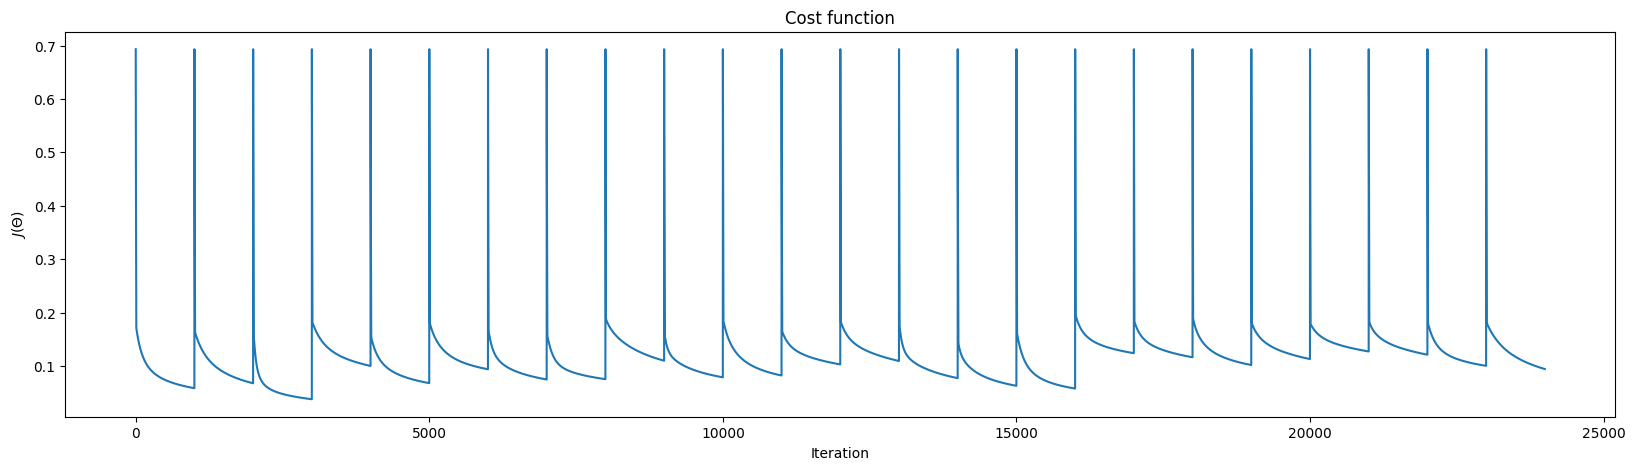

In [109]:
plt.figure(figsize=(20, 5))

plt.plot(all_J)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function")
plt.show()

# Accuracy

In [110]:
# Training
pred = predictOneVsAll(all_theta,X_train)
print("Training Accuracy: ", accuracy_score(y_train,pred))
# Validation
pred1 = predictOneVsAll(all_theta,X_val)
print("Validation Accuracy: ", accuracy_score(y_val,pred1))
# Test
pred2 = predictOneVsAll(all_theta,X_test)
print("Test Accuracy: ",accuracy_score(y_test,pred2))


Training Accuracy:  0.7481333090511747
Validation Accuracy:  0.7352030595519942
Test Accuracy:  0.6140546569994423


## Classification Report

In [111]:
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       331
           1       0.87      0.81      0.84       432
           2       0.80      0.74      0.77       310
           3       0.57      0.61      0.59       245
           4       0.77      0.87      0.81       498
           5       0.61      0.83      0.71       247
           6       0.82      0.59      0.68       348
           7       0.94      0.70      0.80       436
           8       0.55      0.67      0.60       288
           9       0.47      0.48      0.47       331
          10       0.75      1.00      0.85       209
          11       0.66      0.26      0.37       394
          12       0.44      0.39      0.41       291
          13       0.67      0.48      0.56       246
          14       0.89      0.94      0.91       347
          15       0.47      0.84      0.60       164
          16       0.15      0.24      0.19       144
          17       0.18    

## Confusion matrix

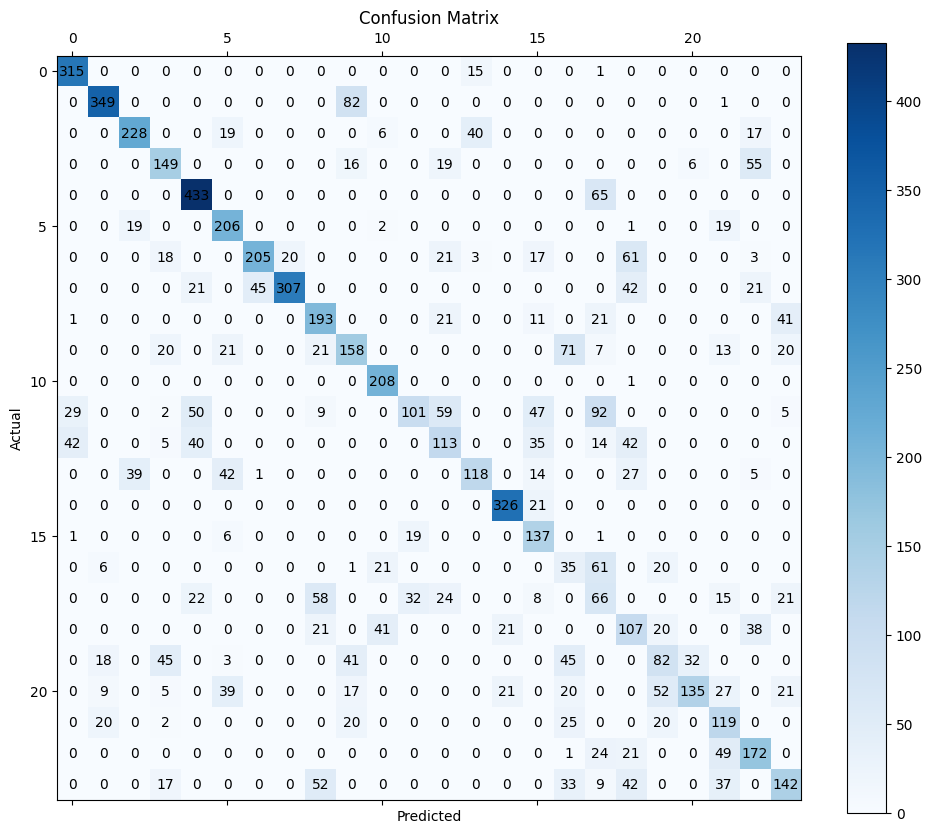

In [112]:
confusion = confusion_matrix(y_test, pred2)

fig, ax = plt.subplots(figsize=(12, 10)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()